<a href="https://colab.research.google.com/github/JackyL504/FYP/blob/main/Signal_decomposition_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install EMD-signal
!pip install ipython-autotime
!pip install pytvfemd
!pip install emd
!pip install EntropyHub
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16.5 s (started: 2022-10-07 14:11:32 +00:00)


In [ ]:
import pandas as pd
import scipy
from scipy.interpolate import pchip_interpolate
from scipy.fft import rfft, rfftfreq, fft, fftfreq
import torch
import numpy as np
from matplotlib import pyplot as plt
from PyEMD import EMD, EEMD, CEEMDAN
from PyEMD.checks import whitenoise_check
from pytvfemd import tvfemd
import warnings
import emd
import EntropyHub as EH
warnings.filterwarnings('ignore')

# from google.colab import drive
# drive.mount('/content/drive')

time: 4.45 ms (started: 2022-10-07 15:05:47 +00:00)


# PD1_EAT1


In [ ]:
pathL = "https://github.com/JackyL504/FYP/raw/main/PD1_EAT1/TestDataL.csv"
pathP = "https://github.com/JackyL504/FYP/raw/main/PD1_EAT1/TestDataP.csv"
pathU = "https://github.com/JackyL504/FYP/raw/main/PD1_EAT1/TestDataU.csv"
# lower_arm = pd.read_excel(path,"TestDataL")
lower_arm = pd.read_csv(pathL, header=None)
palm = pd.read_csv(pathP, header=None)
upper_arm = pd.read_csv(pathU, header=None)

timeRaw = (lower_arm[0]/1000).array
alphaRaw = lower_arm[1].array
betaRaw = lower_arm[2].array
gammaRaw = lower_arm[3].array


time: 771 ms (started: 2022-10-07 14:11:48 +00:00)


## Data Preprocessing
- Interpolation
- Detrend

In [ ]:
# Interpolation
TimeSample = 0.037
SampleRate = 62
timeRaw = timeRaw - timeRaw[0]
time = np.arange(timeRaw[0], timeRaw[-1], TimeSample)
alpha = scipy.interpolate.pchip_interpolate(timeRaw, alphaRaw, time)
# beta = scipy.interpolate.pchip_interpolate(timeRaw, betaRaw, time)
# gamma = scipy.interpolate.pchip_interpolate(timeRaw, gammaRaw, time)

# Detrend
alpha = scipy.signal.detrend(alpha)
# beta = scipy.signal.detrend(beta)
# gamma = scipy.signal.detrend(gamma)


time: 18.6 ms (started: 2022-10-07 14:11:49 +00:00)


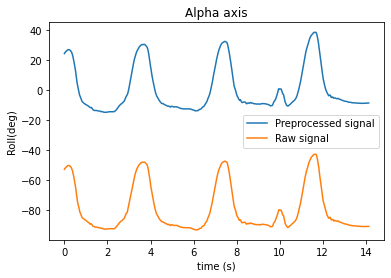

time: 336 ms (started: 2022-10-07 14:11:49 +00:00)


In [ ]:
# Plot 
plt.figure()
plt.plot(time, alpha, label = "Preprocessed signal")
plt.plot(timeRaw, alphaRaw, label = "Raw signal")
plt.xlabel('time (s)')
plt.ylabel('Roll(deg)')
plt.title('Alpha axis')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(time, beta, label = "Preprocessed signal")
# plt.plot(timeRaw, betaRaw, label = "Raw signal")
# plt.xlabel('time (s)')
# plt.ylabel('Pitch(deg)')
# plt.title('Beta axis')
# plt.legend(loc = "upper right")
# plt.show()

# plt.figure()
# plt.plot(time, gamma, label = "Preprocessed signal")
# plt.plot(timeRaw, gammaRaw, label = "Raw signal")
# plt.xlabel('time (s)')
# plt.ylabel('Yaw(deg)')
# plt.title('Gamma axis')
# plt.legend()
# plt.show()

## Signal Decomposition


### EMD PyEMD

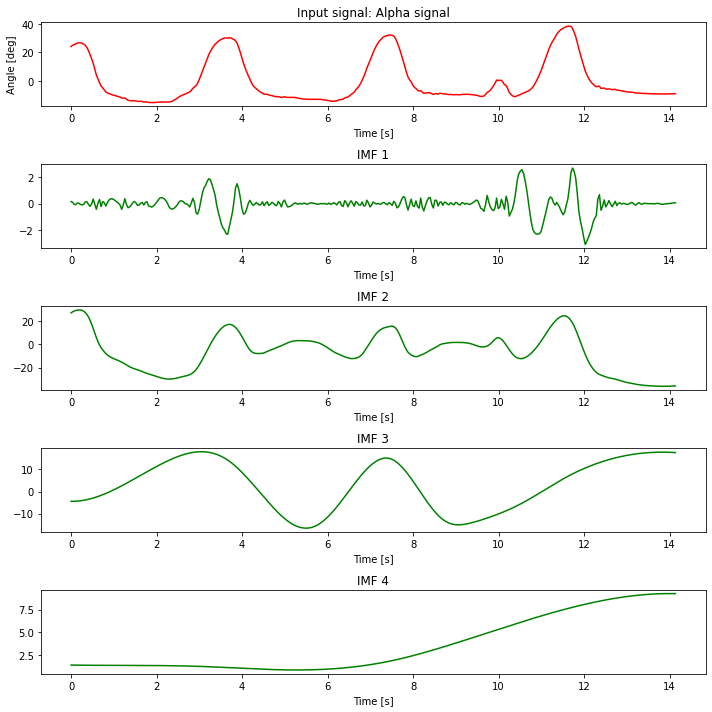

{1: 1, 2: 1, 3: 1, 4: 1}
time: 1.22 s (started: 2022-10-07 15:06:11 +00:00)


In [ ]:
imf = EMD().emd(alpha,time)
N = imf.shape[0]+1

# Plot results
plt.figure(figsize=(10, 10))
plt.subplot(N,1,1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n, imff in enumerate(imf):
    plt.subplot(N,1,n+2)
    plt.plot(time, imff, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

significant_imfs = whitenoise_check(imf, test_name='apriori')
print(significant_imfs)

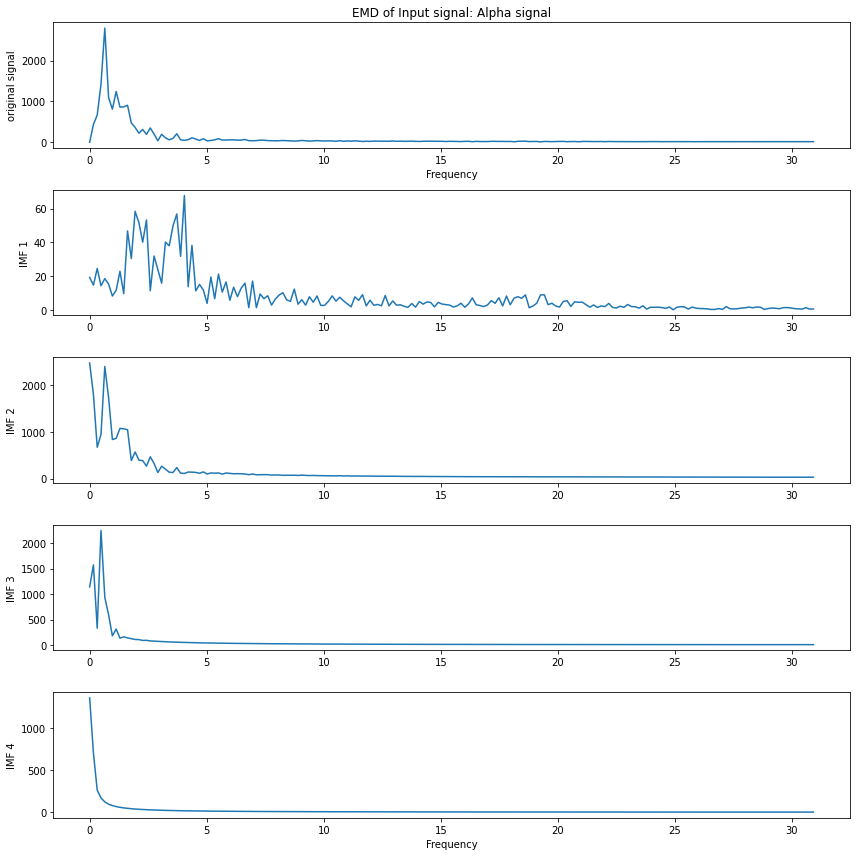

time: 815 ms (started: 2022-10-07 14:11:50 +00:00)


In [ ]:
# Plot results
nIMFs = imf.shape[0]
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EMD of Input signal: Alpha signal")
plt.xlabel("Frequency")
plt.ylabel("original signal")

for n, imff in enumerate(imf):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imff
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

#### Hilbert Huang Transform

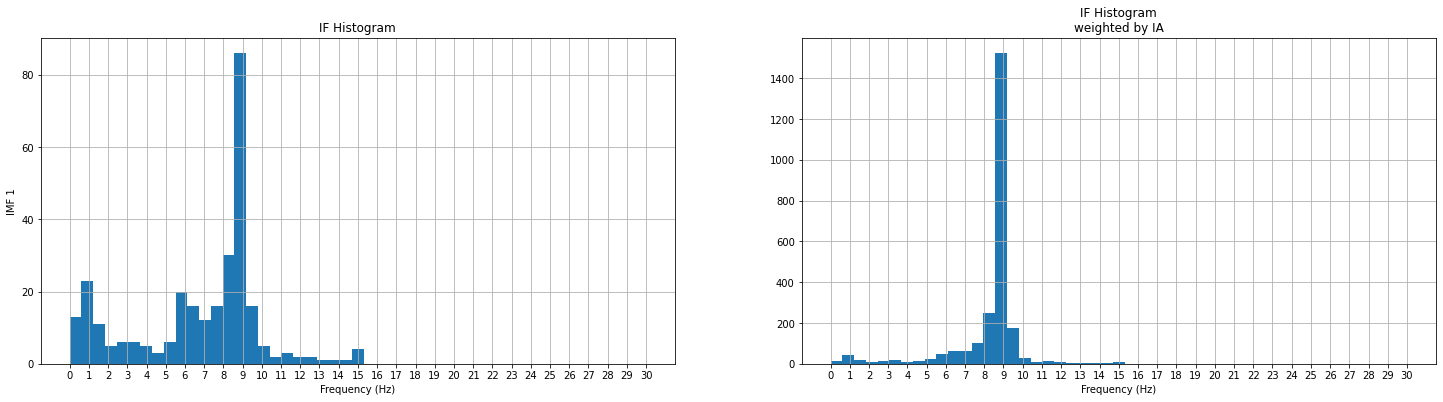

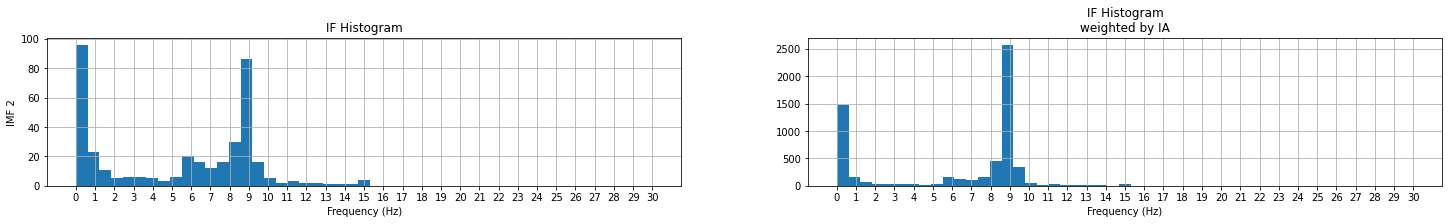

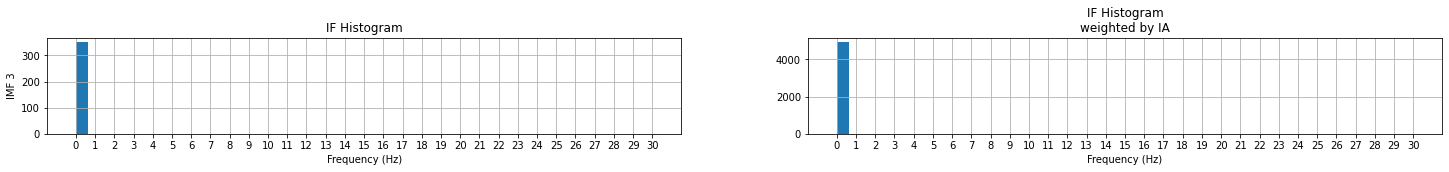

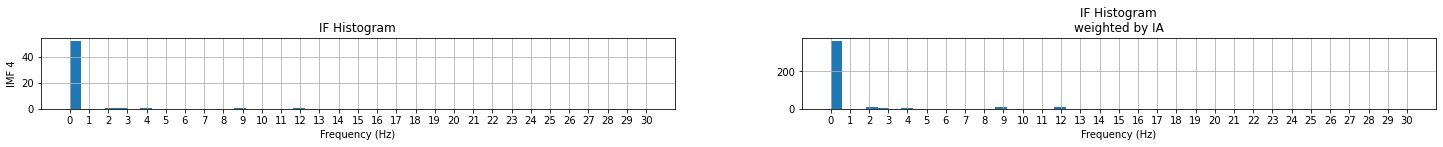

time: 3.25 s (started: 2022-10-07 14:11:51 +00:00)


In [ ]:
# IP, IF, IA = emd.spectra.frequency_transform(imf, SampleRate, 'nht')
IP, IF, IA = emd.spectra.frequency_transform(imf, SampleRate, 'hilbert')

# IF = IF.T
# IA = IA.T

# N = IF.shape[1]+1
# plt.figure(figsize=(20, 910))

for n, iF in enumerate(IF):
  plt.figure(figsize=(25, 6))
  plt.subplot(n+1, 2, 2*n+1)
  # Plot a simple histogram using frequency bins from 0-20Hz
  plt.hist(iF, np.linspace(0, 30))
  plt.grid(True)
  plt.title('IF Histogram')
  plt.xticks(np.arange(0, 31, 1))
  plt.ylabel("IMF %i" %(n+1))
  plt.xlabel('Frequency (Hz)')

  plt.subplot(n+1, 2, 2*n+2)
  # Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
  plt.hist(iF, np.linspace(0, 30), weights=IA[n,:])
  plt.grid(True)
  plt.title('IF Histogram\nweighted by IA')
  plt.xticks(np.arange(0, 31, 1))
  plt.xlabel('Frequency (Hz)')

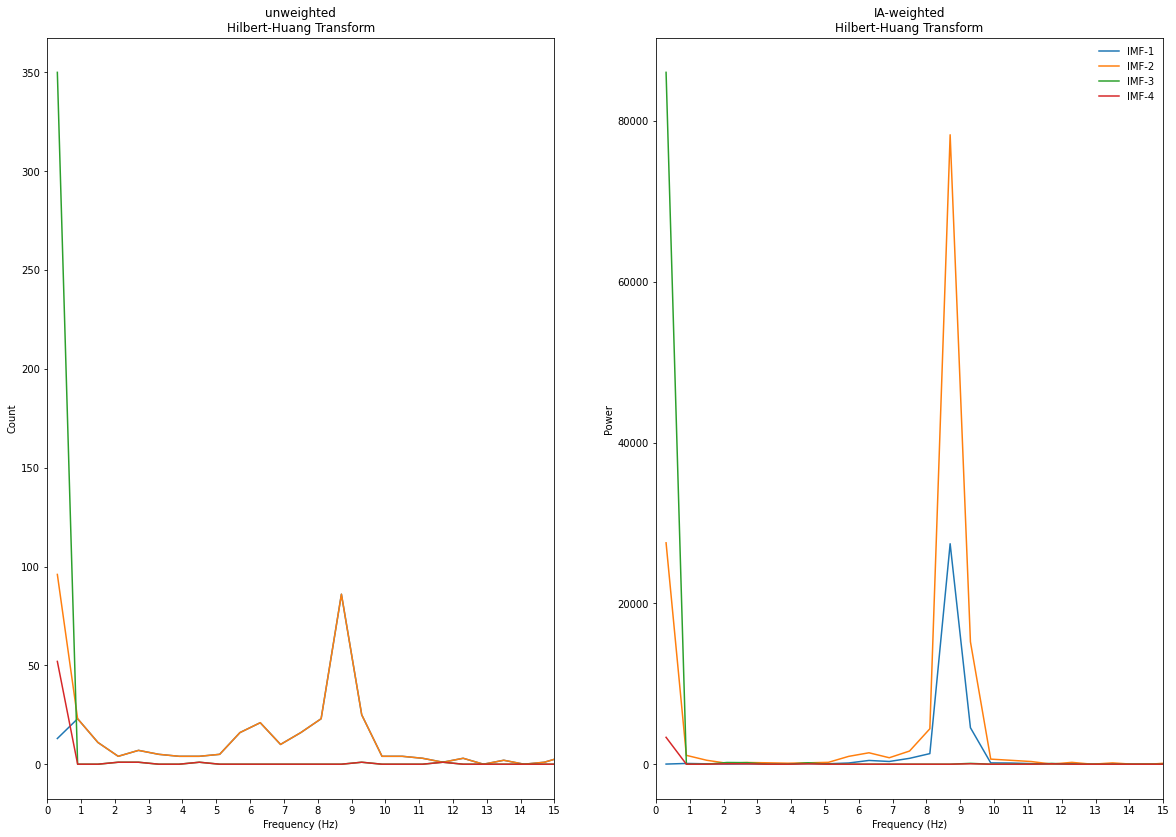

time: 717 ms (started: 2022-10-07 14:11:54 +00:00)


In [ ]:
# Compute frequency statistics
IP, IF, IA = emd.spectra.frequency_transform(imf, SampleRate, 'hilbert')

IF = IF.T
IA = IA.T

f, spectrum = emd.spectra.hilberthuang(IF, IA, (1, 50, 25))

freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 30, 50, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# # Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

plt.figure(figsize=(20, 14))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
plt.xticks(np.arange(100)*1)
plt.xlim(0, 15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(100)*1)
plt.xlim(0, 15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)


#### Features

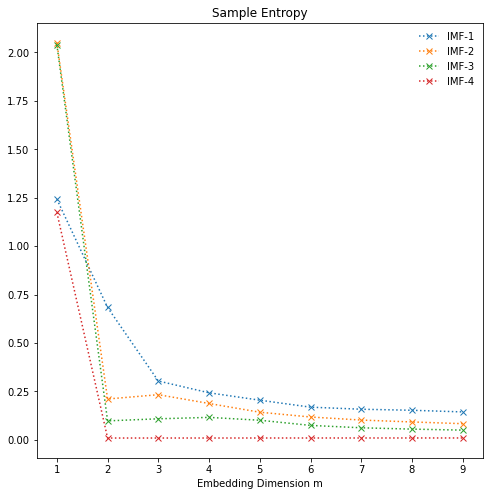

time: 856 ms (started: 2022-10-07 14:11:55 +00:00)


In [ ]:
m = 8
mean = np.empty(imf.shape[0])
std = np.empty(imf.shape[0])
skewness = np.empty(imf.shape[0])
kurtosis = np.empty(imf.shape[0])
PeaktoRMS = np.empty(imf.shape[0])

for n, imff in enumerate(imf):
  std[n] = np.std(imff)

  nobs, minmax, mean[n], variance, skewness[n], kurtosis[n] = scipy.stats.describe(imff)

  absmax = max(np. absolute(minmax))
  rms = np.sqrt(np.mean(imff**2))
  PeaktoRMS[n] = absmax/rms

  SampEnTemp, _, _ = EH.SampEn(imff, m=m, tau = 1)
  if n == 0:
    sampEn = SampEnTemp
  else:
    sampEn  = np.vstack([sampEn, SampEnTemp])
  
plt.figure(figsize=(8, 8))
N = sampEn.shape[0]+1
for n, sampen in enumerate(sampEn):
  # plt.subplot(N,1,n+2)
  plt.plot(np.linspace(1,9,9), sampen, marker="x", linestyle='dotted')
  plt.title("Sample Entropy")
  plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)
  plt.xlabel("Embedding Dimension m")

### EMD emd package (not used)





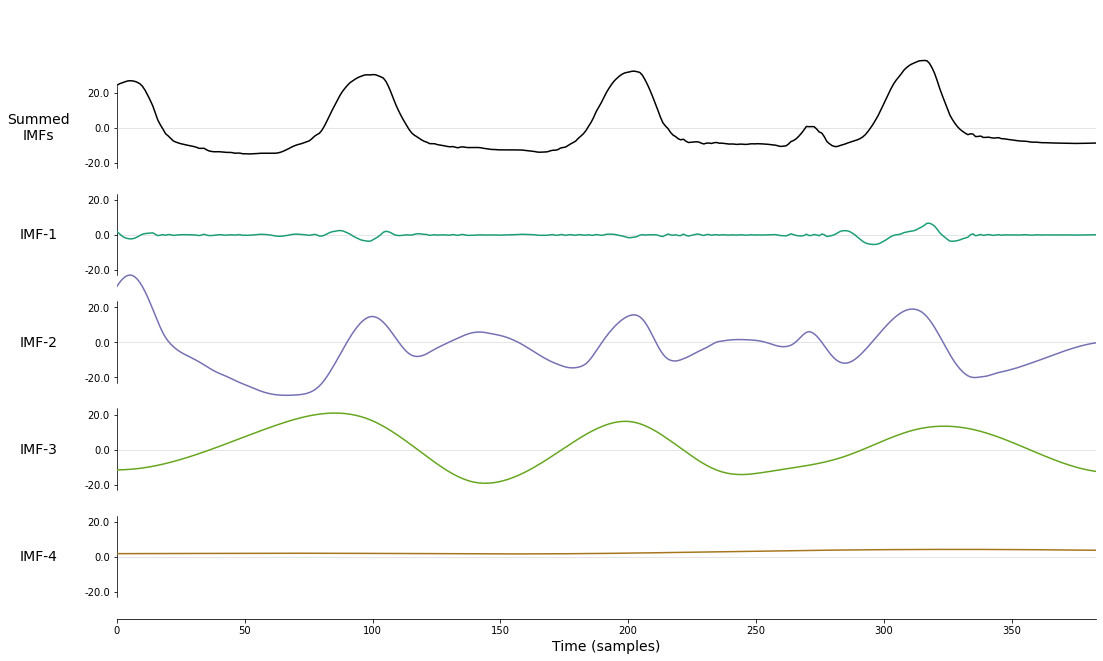

time: 431 ms (started: 2022-10-07 14:11:56 +00:00)


In [ ]:
imf = emd.sift.sift(alpha)
emd.plotting.plot_imfs(imf)

### EEMD PyEMD

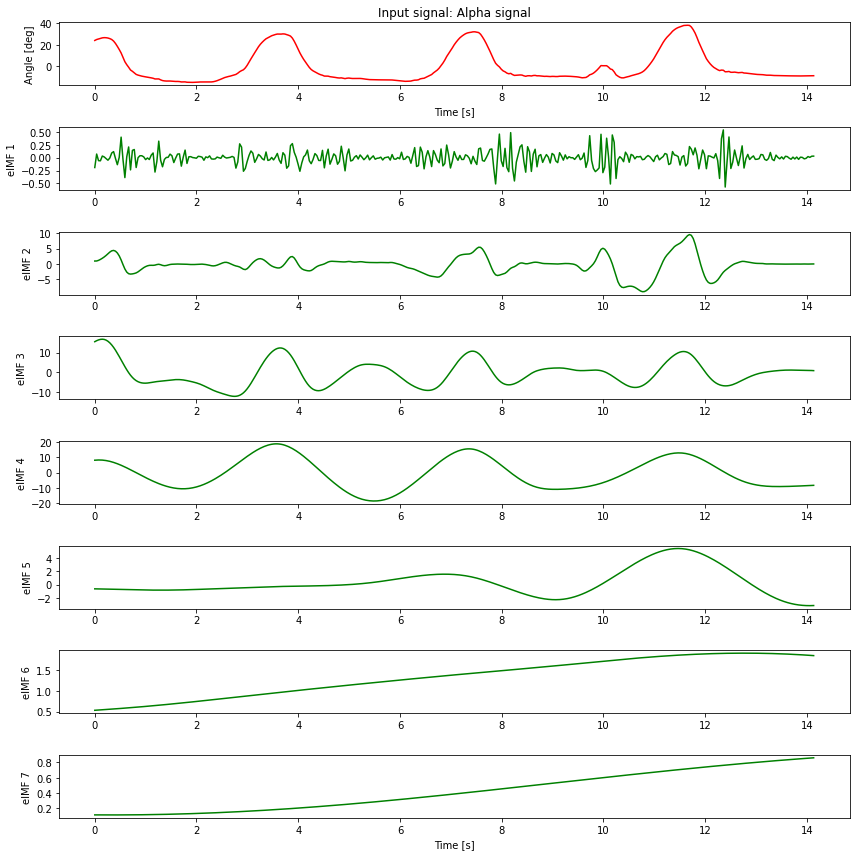

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
time: 7.86 s (started: 2022-10-07 15:23:18 +00:00)


In [ ]:
# Assign EEMD to `eemd` variable
eemd = EEMD(noise_width = 0.005)

# # Say we want detect extrema using parabolic method
# eemd.EMD.extrema_detection="parabol"

# Execute EEMD on S
eIMFs = eemd.eemd(alpha, time)
nIMFs = eIMFs.shape[0]

# Plot results
# emd.plotting.plot_imfs(eIMFs.T)

plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(time, eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

significant_imfs = whitenoise_check(eIMFs, test_name='apriori')
print(significant_imfs)

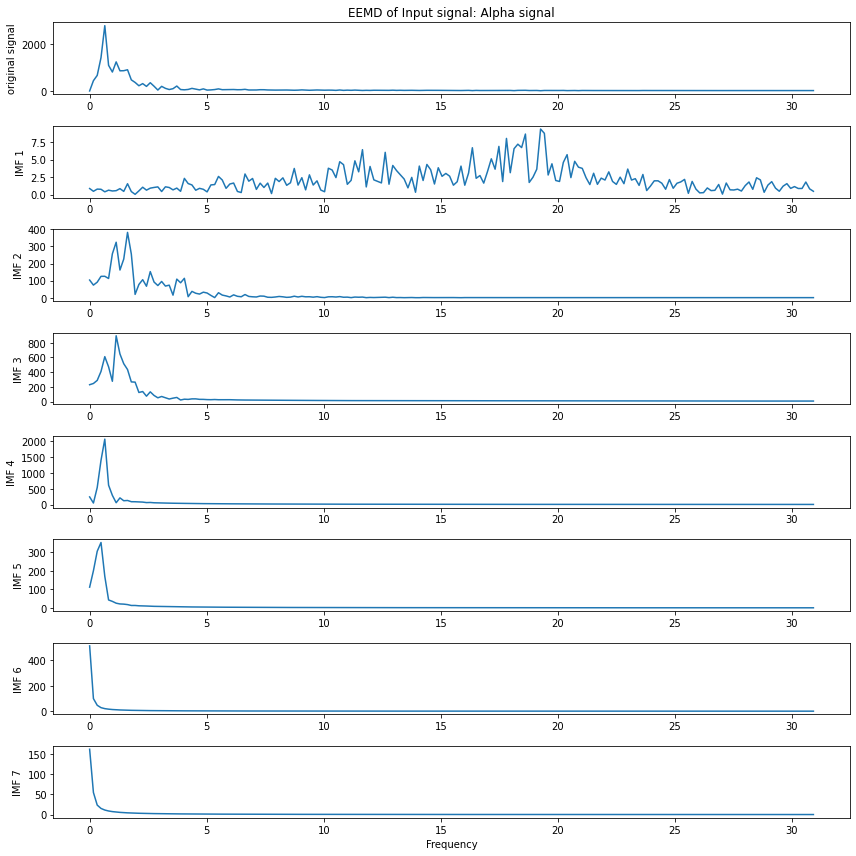

time: 951 ms (started: 2022-10-07 15:23:27 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EEMD of Input signal: Alpha signal")
plt.ylabel("original signal")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = eIMFs[n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

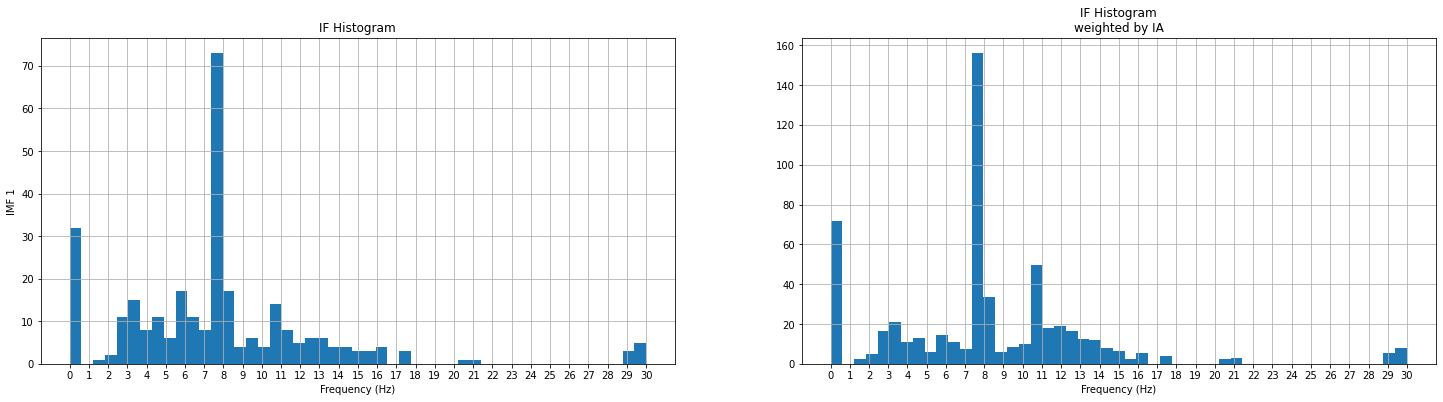

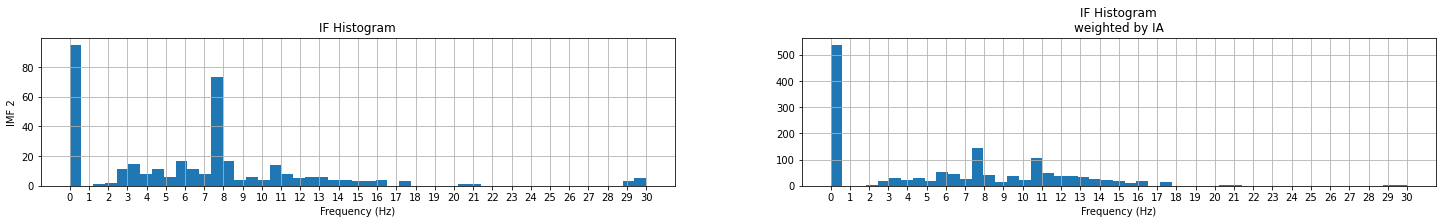

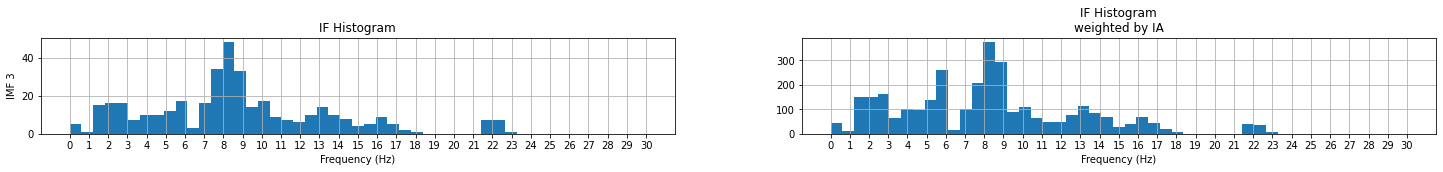

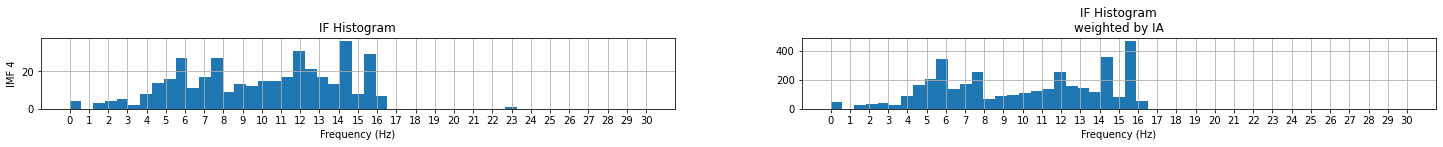

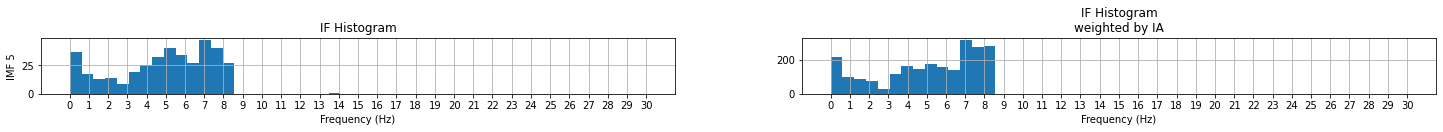

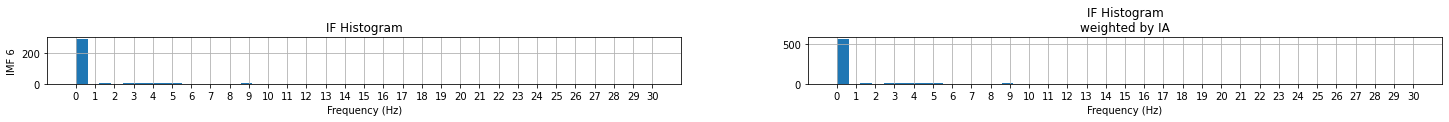

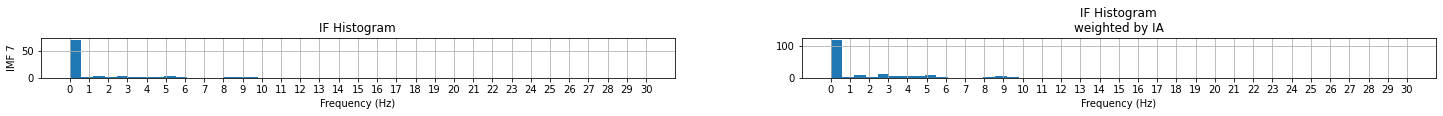

time: 4.88 s (started: 2022-10-07 15:23:29 +00:00)


In [ ]:
# IP, IF, IA = emd.spectra.frequency_transform(imf, SampleRate, 'nht')
IP, IF, IA = emd.spectra.frequency_transform(eIMFs, SampleRate, 'hilbert')

# IF = IF.T
# IA = IA.T

# N = IF.shape[1]+1
# plt.figure(figsize=(20, 910))

for n, iF in enumerate(IF):
  plt.figure(figsize=(25, 6))
  plt.subplot(n+1, 2, 2*n+1)
  # Plot a simple histogram using frequency bins from 0-20Hz
  plt.hist(iF, np.linspace(0, 30))
  plt.grid(True)
  plt.title('IF Histogram')
  plt.xticks(np.arange(0, 31, 1))
  plt.ylabel("IMF %i" %(n+1))
  plt.xlabel('Frequency (Hz)')

  plt.subplot(n+1, 2, 2*n+2)
  # Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
  plt.hist(iF, np.linspace(0, 30), weights=IA[n,:])
  plt.grid(True)
  plt.title('IF Histogram\nweighted by IA')
  plt.xticks(np.arange(0, 31, 1))
  plt.xlabel('Frequency (Hz)')

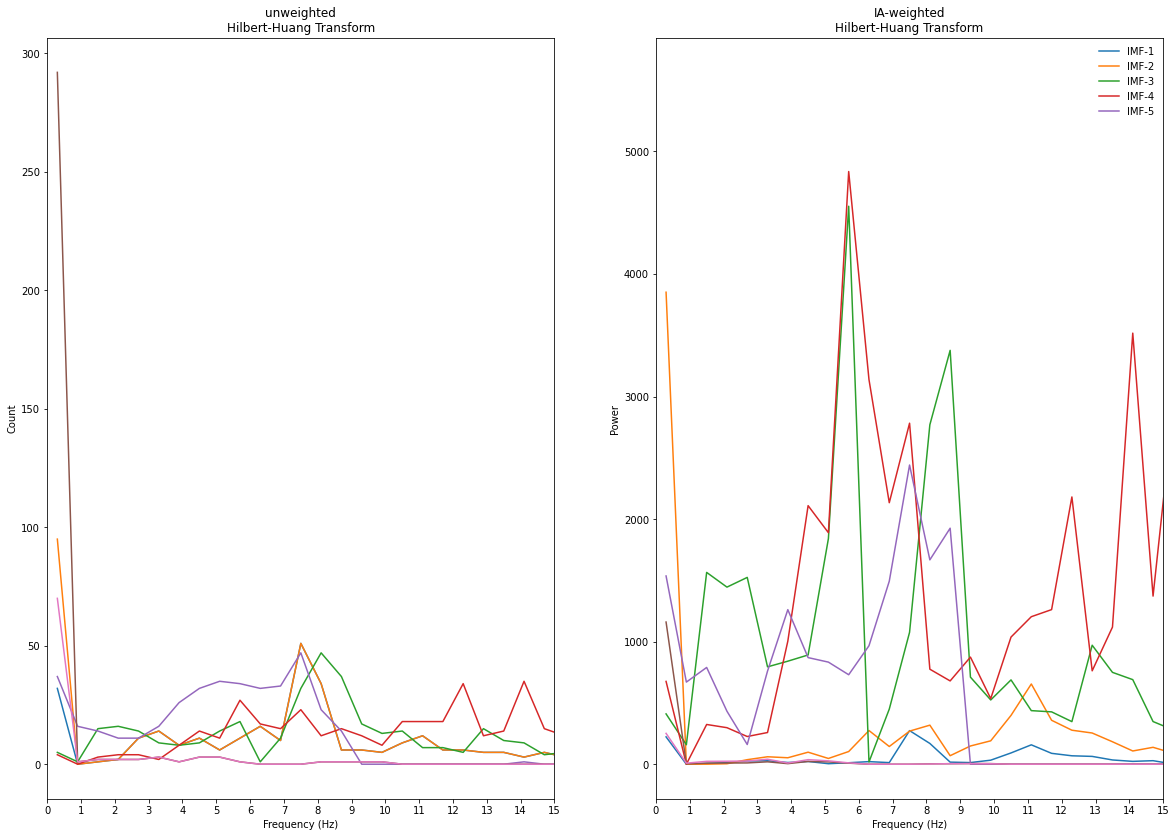

time: 744 ms (started: 2022-10-07 15:23:34 +00:00)


In [ ]:
# Compute frequency statistics
IP, IF, IA = emd.spectra.frequency_transform(eIMFs, SampleRate, 'hilbert')

IF = IF.T
IA = IA.T

f, spectrum = emd.spectra.hilberthuang(IF, IA, (1, 50, 25))

freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 30, 50, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# # Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

plt.figure(figsize=(20, 14))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
plt.xticks(np.arange(100)*1)
plt.xlim(0, 15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(100)*1)
plt.xlim(0, 15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)


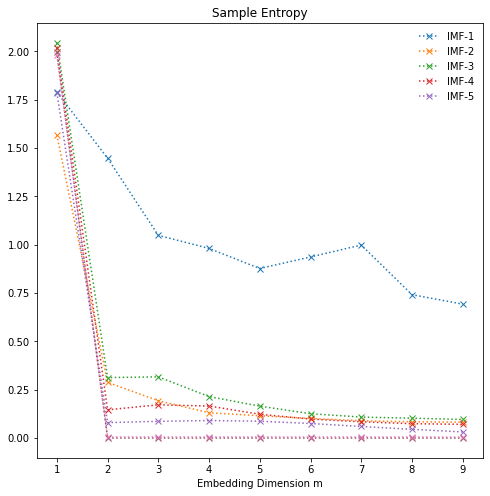

time: 1.25 s (started: 2022-10-07 15:23:35 +00:00)


In [ ]:
m = 8
mean = np.empty(eIMFs.shape[0])
std = np.empty(eIMFs.shape[0])
skewness = np.empty(eIMFs.shape[0])
kurtosis = np.empty(eIMFs.shape[0])
PeaktoRMS = np.empty(eIMFs.shape[0])

for n, imff in enumerate(eIMFs):
  std[n] = np.std(imff)

  nobs, minmax, mean[n], variance, skewness[n], kurtosis[n] = scipy.stats.describe(imff)

  absmax = max(np. absolute(minmax))
  rms = np.sqrt(np.mean(imff**2))
  PeaktoRMS[n] = absmax/rms

  SampEnTemp, _, _ = EH.SampEn(imff, m=m, tau = 1)
  if n == 0:
    sampEn = SampEnTemp
  else:
    sampEn  = np.vstack([sampEn, SampEnTemp])
  
plt.figure(figsize=(8, 8))
N = sampEn.shape[0]+1
for n, sampen in enumerate(sampEn):
  # plt.subplot(N,1,n+2)
  plt.plot(np.linspace(1,9,9), sampen, marker="x", linestyle='dotted')
  plt.title("Sample Entropy")
  plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)
  plt.xlabel("Embedding Dimension m")

In [ ]:
sampEn

array([[1.67720319, 0.93330307, 0.39333226, 0.27022063, 0.22401738,
        0.19734124, 0.18358339, 0.18342366, 0.17897081],
       [1.76068339, 0.30149624, 0.21702447, 0.16656192, 0.13914516,
        0.12274655, 0.11809249, 0.11297696, 0.11305629],
       [2.13430042, 0.17348887, 0.20600769, 0.19761462, 0.1672092 ,
        0.14098593, 0.11897068, 0.10022586, 0.08158945],
       [1.91032542, 0.07723541, 0.08379232, 0.08975607, 0.08432382,
        0.08637869, 0.08182779, 0.06208167, 0.05187299],
       [1.84578112, 0.00454546, 0.00451149, 0.00447588, 0.00443861,
        0.00439964, 0.00435892, 0.00431642, 0.00427209]])

time: 18.7 ms (started: 2022-10-07 15:22:27 +00:00)


### EEMD emd package (not used)

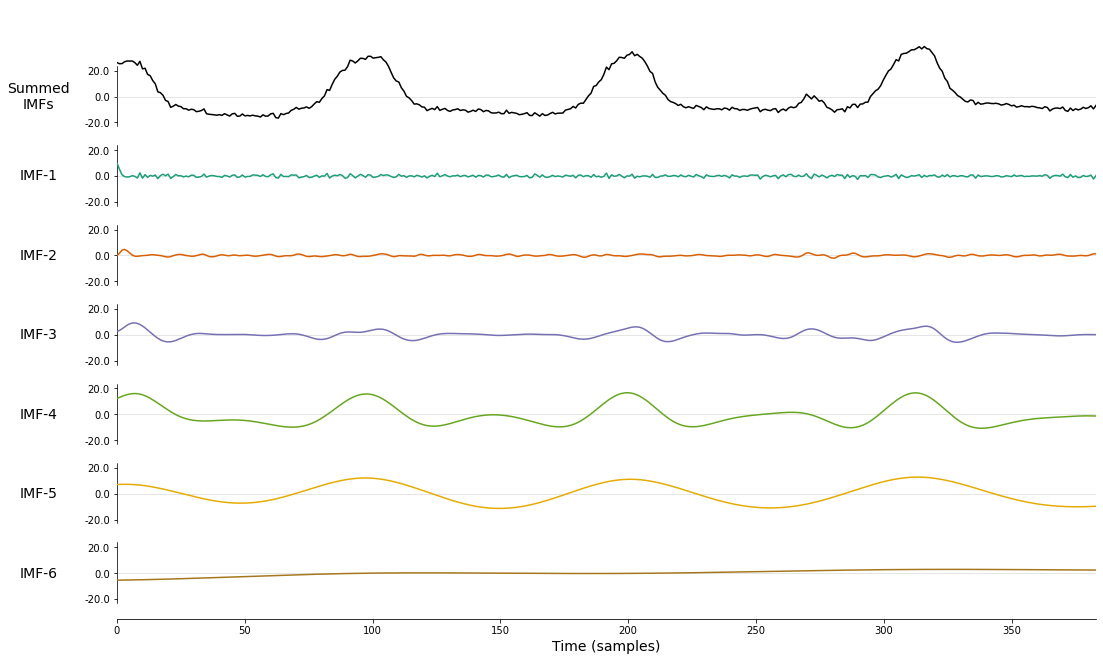

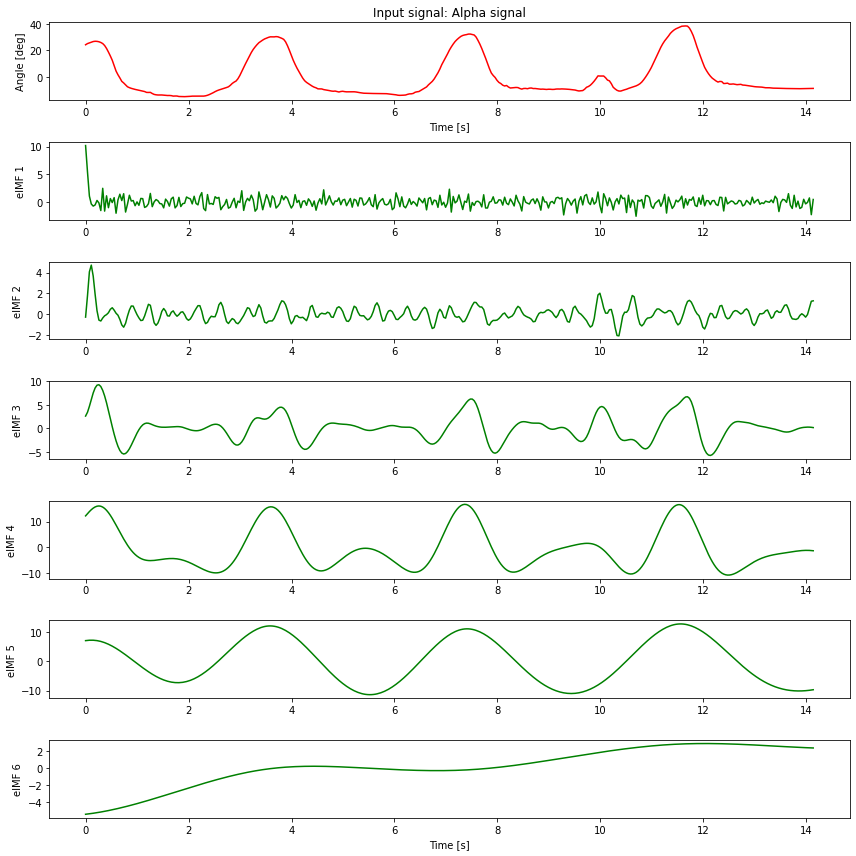

time: 2min (started: 2022-10-07 14:12:24 +00:00)


In [ ]:
imf = emd.sift.ensemble_sift(alpha, nensembles=1000, ensemble_noise=2, noise_mode='single', nprocesses=20, sift_thresh=1e-08, max_imfs=None, verbose=None, imf_opts=None, envelope_opts=None, extrema_opts=None)
emd.plotting.plot_imfs(imf)

nIMFs = imf.shape[1]

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(time, imf[:,n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

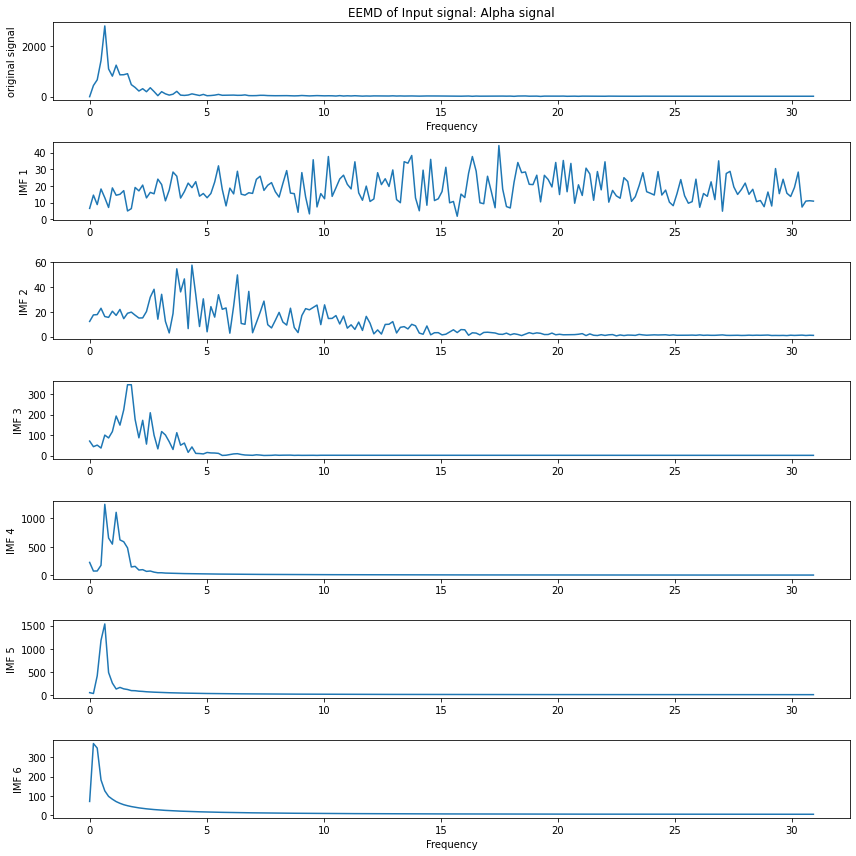

time: 881 ms (started: 2022-10-07 14:14:25 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EEMD of Input signal: Alpha signal")
plt.xlabel("Frequency")
plt.ylabel("original signal")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imf[:,n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

### Masked EMD


In [ ]:
# imf = emd.sift.mask_sift(alpha, mask_amp = 0.4, mask_freqs=13.5*TimeSample, mask_step_factor = 1.5, max_imfs=20)
imf = emd.sift.iterated_mask_sift(alpha, mask_amp = 0.4, sample_rate=62, max_imfs=5, mask_0='random')

# emd.plotting.plot_imfs(imf)

time: 731 ms (started: 2022-10-07 14:14:26 +00:00)


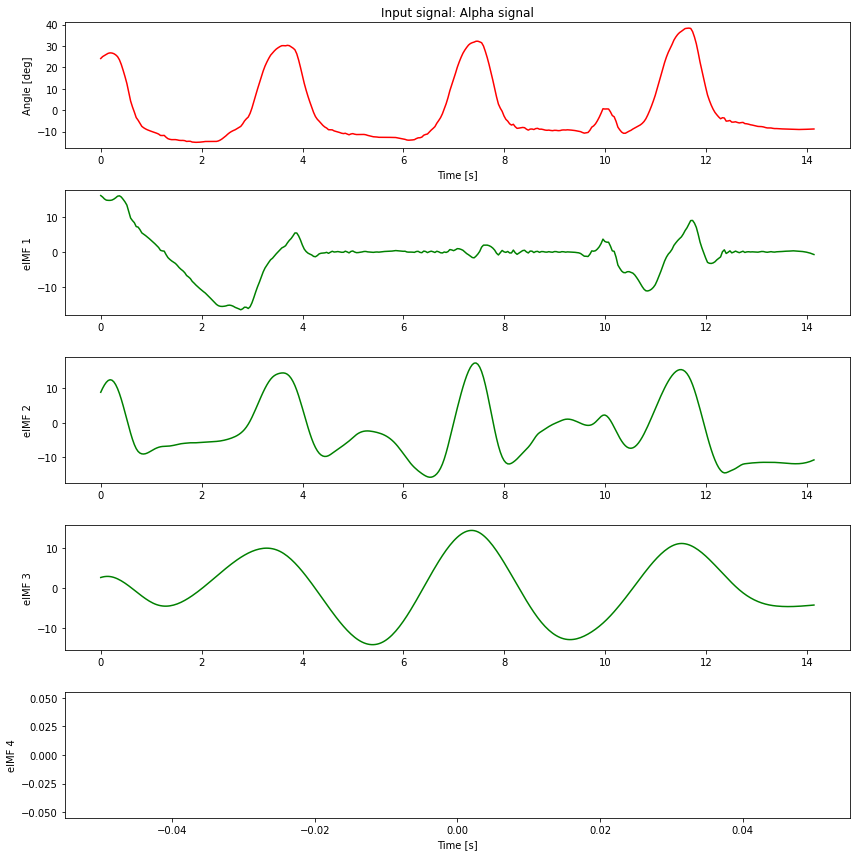

time: 687 ms (started: 2022-10-07 14:14:27 +00:00)


In [ ]:
nIMFs = imf.shape[1]

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(time, imf[:,n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

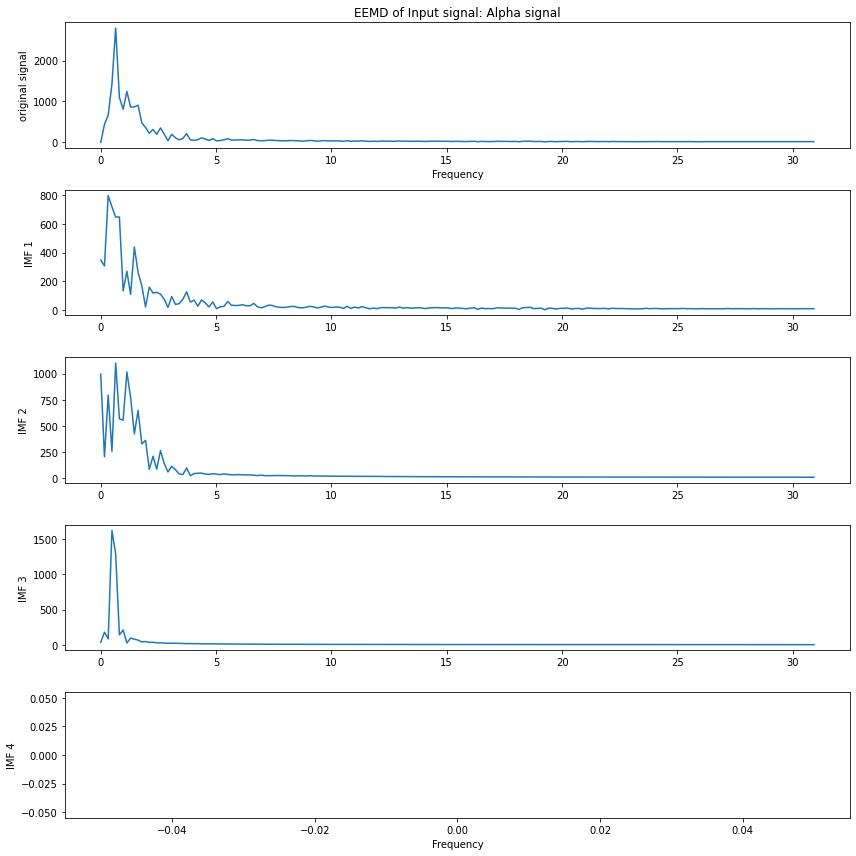

time: 690 ms (started: 2022-10-07 14:14:27 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EEMD of Input signal: Alpha signal")
plt.xlabel("Frequency")
plt.ylabel("original signal")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imf[:,n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

### CEEMDAN

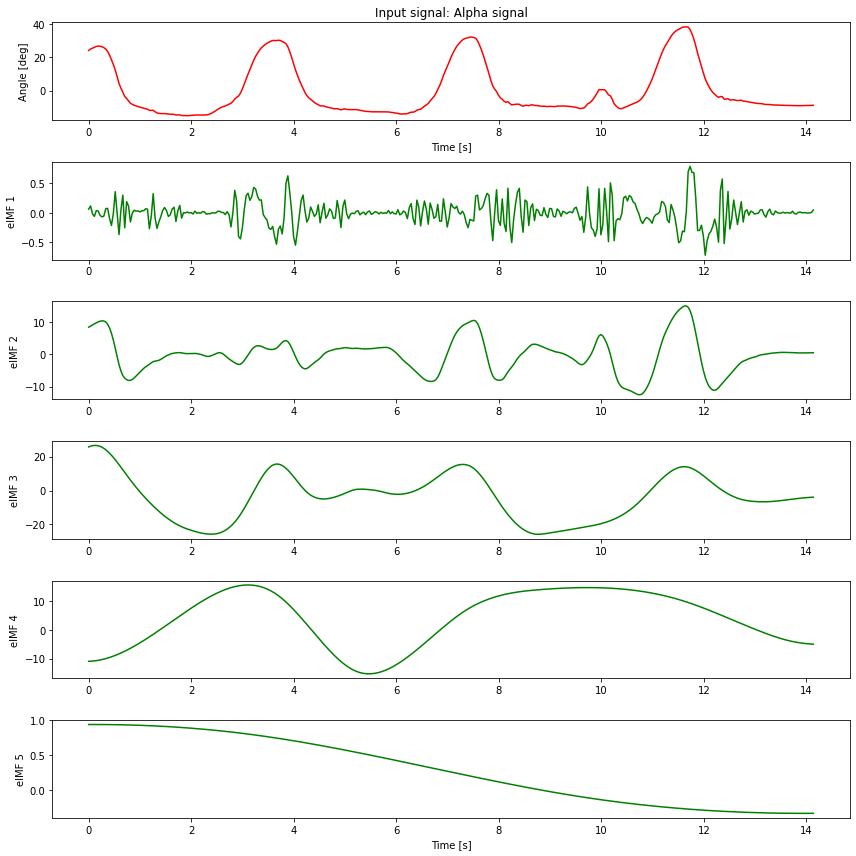

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
time: 11.5 s (started: 2022-10-07 15:09:31 +00:00)


In [ ]:
#default
ceemdan = CEEMDAN()

# # Say we want detect extrema using parabolic method
# ceemdan.EMD.extrema_detection="parabol"

# Execute CEEMDAN on S
ceIMFs = ceemdan.ceemdan(alpha, time)
cnIMFs = ceIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(cnIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(cnIMFs):
    plt.subplot(cnIMFs+1, 1, n+2)
    plt.plot(time, ceIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

significant_imfs = whitenoise_check(ceIMFs, test_name='apriori')
print(significant_imfs)

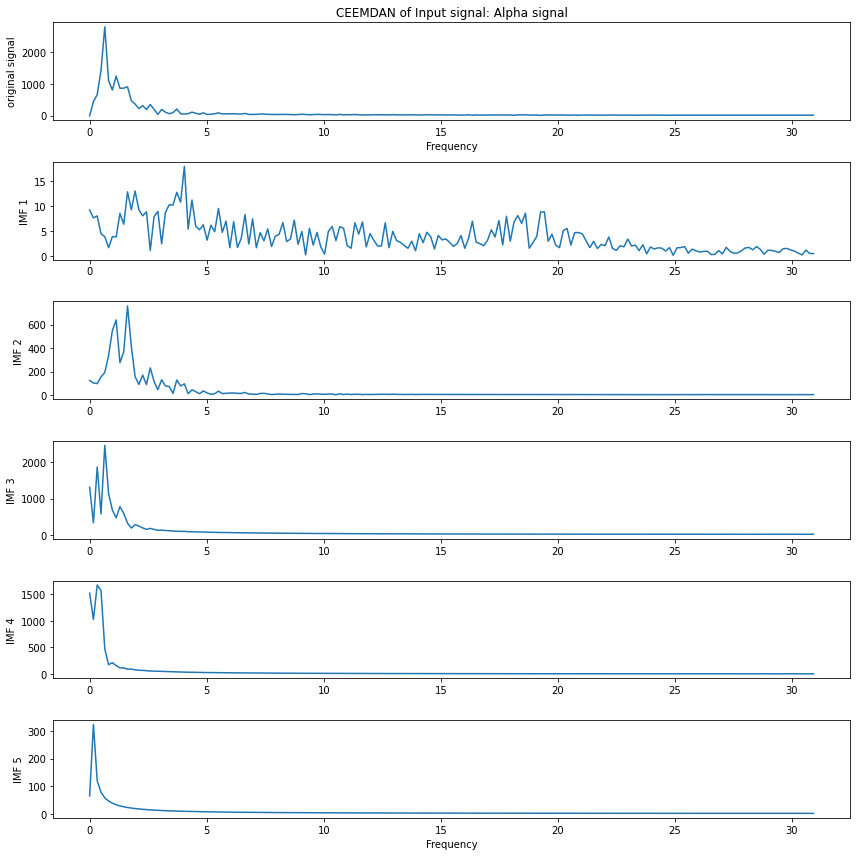

time: 1.09 s (started: 2022-10-07 14:14:36 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(cnIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d =1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("CEEMDAN of Input signal: Alpha signal")
plt.xlabel("Frequency")
plt.ylabel("original signal")

for n in range(cnIMFs):
    plt.subplot(cnIMFs+1, 1, n+2)
    signal = ceIMFs[n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

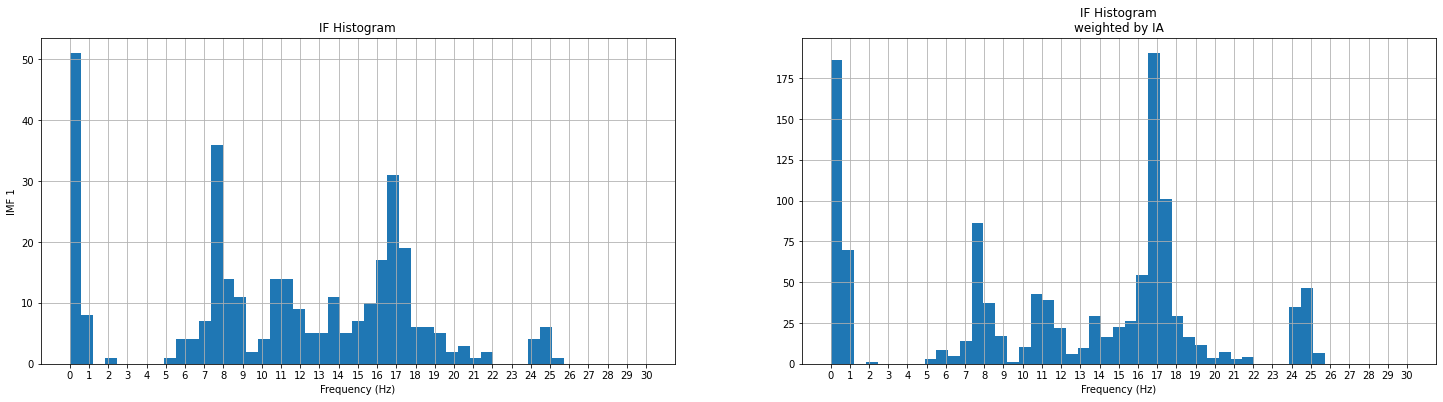

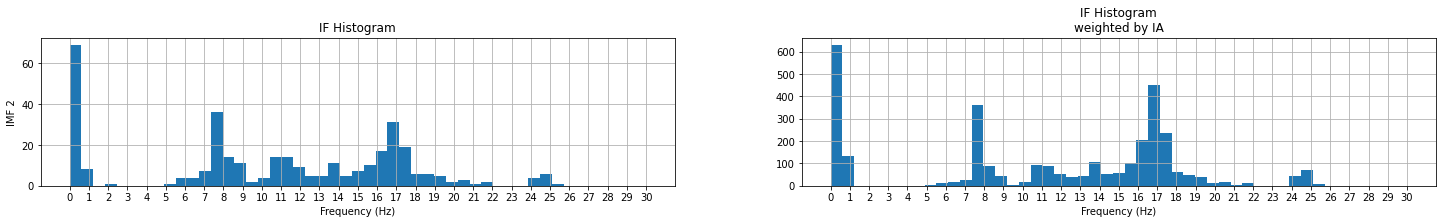

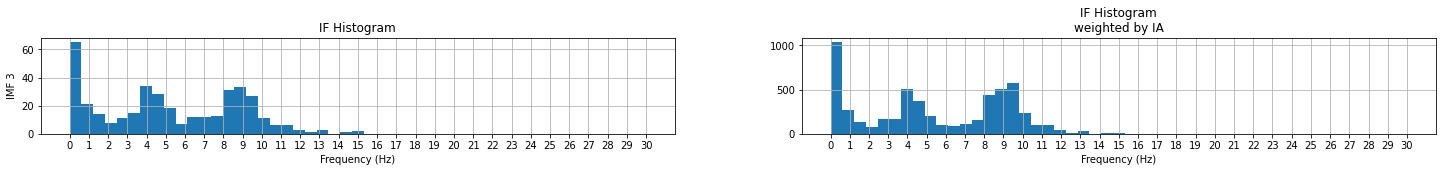

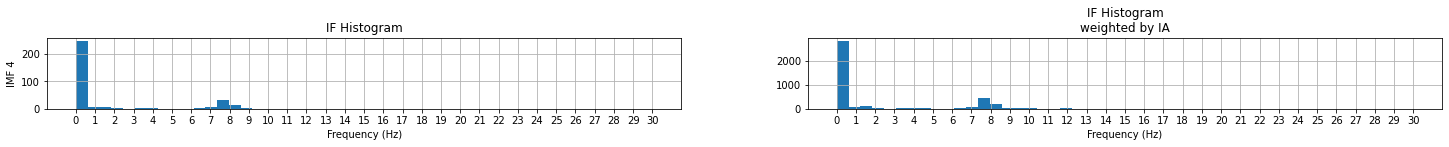

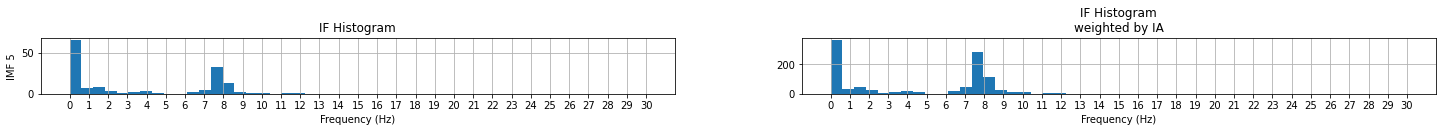

time: 3.29 s (started: 2022-10-07 14:14:37 +00:00)


In [ ]:
# IP, IF, IA = emd.spectra.frequency_transform(imf, SampleRate, 'nht')
IP, IF, IA = emd.spectra.frequency_transform(ceIMFs, SampleRate, 'hilbert')

# IF = IF.T
# IA = IA.T

# N = IF.shape[1]+1
# plt.figure(figsize=(20, 910))

for n, iF in enumerate(IF):
  plt.figure(figsize=(25, 6))
  plt.subplot(n+1, 2, 2*n+1)
  # Plot a simple histogram using frequency bins from 0-20Hz
  plt.hist(iF, np.linspace(0, 30))
  plt.grid(True)
  plt.title('IF Histogram')
  plt.xticks(np.arange(0, 31, 1))
  plt.ylabel("IMF %i" %(n+1))
  plt.xlabel('Frequency (Hz)')

  plt.subplot(n+1, 2, 2*n+2)
  # Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
  plt.hist(iF, np.linspace(0, 30), weights=IA[n,:])
  plt.grid(True)
  plt.title('IF Histogram\nweighted by IA')
  plt.xticks(np.arange(0, 31, 1))
  plt.xlabel('Frequency (Hz)')

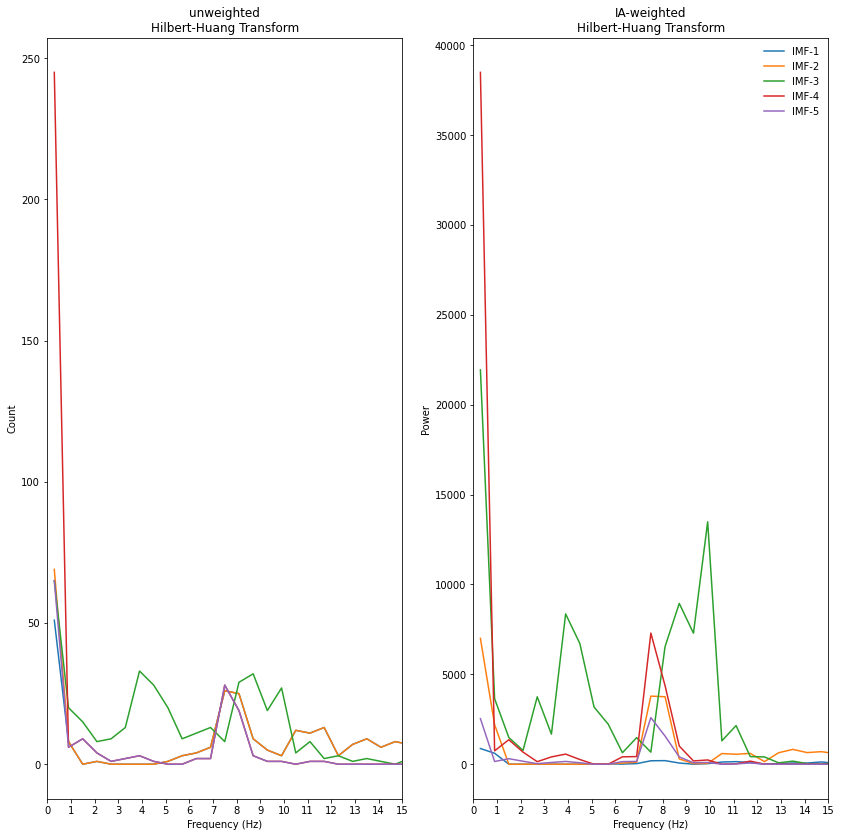

time: 989 ms (started: 2022-10-07 14:14:41 +00:00)


In [ ]:
# Compute frequency statistics
IP, IF, IA = emd.spectra.frequency_transform(ceIMFs, SampleRate, 'hilbert')

IF = IF.T
IA = IA.T

f, spectrum = emd.spectra.hilberthuang(IF, IA, (1, 50, 25))

freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 30, 50, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# # Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

plt.figure(figsize=(14, 14))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
plt.xticks(np.arange(100)*1)
plt.xlim(0, 15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(100)*1)
plt.xlim(0, 15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)


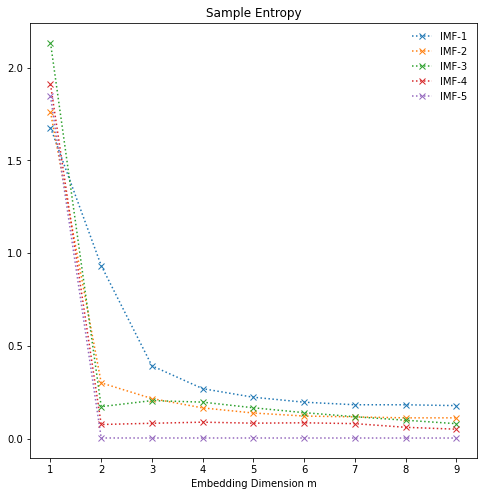

time: 956 ms (started: 2022-10-07 14:14:42 +00:00)


In [ ]:
m = 8
mean = np.empty(ceIMFs.shape[0])
std = np.empty(ceIMFs.shape[0])
skewness = np.empty(ceIMFs.shape[0])
kurtosis = np.empty(ceIMFs.shape[0])
PeaktoRMS = np.empty(ceIMFs.shape[0])

for n, imff in enumerate(ceIMFs):
  std[n] = np.std(imff)

  nobs, minmax, mean[n], variance, skewness[n], kurtosis[n] = scipy.stats.describe(imff)

  absmax = max(np. absolute(minmax))
  rms = np.sqrt(np.mean(imff**2))
  PeaktoRMS[n] = absmax/rms

  SampEnTemp, _, _ = EH.SampEn(imff, m=m, tau = 1)
  if n == 0:
    sampEn = SampEnTemp
  else:
    sampEn  = np.vstack([sampEn, SampEnTemp])
  
plt.figure(figsize=(8, 8))
N = sampEn.shape[0]+1
for n, sampen in enumerate(sampEn):
  # plt.subplot(N,1,n+2)
  plt.plot(np.linspace(1,9,9), sampen, marker="x", linestyle='dotted')
  plt.title("Sample Entropy")
  plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)
  plt.xlabel("Embedding Dimension m")

### TVF-EMD (not used)

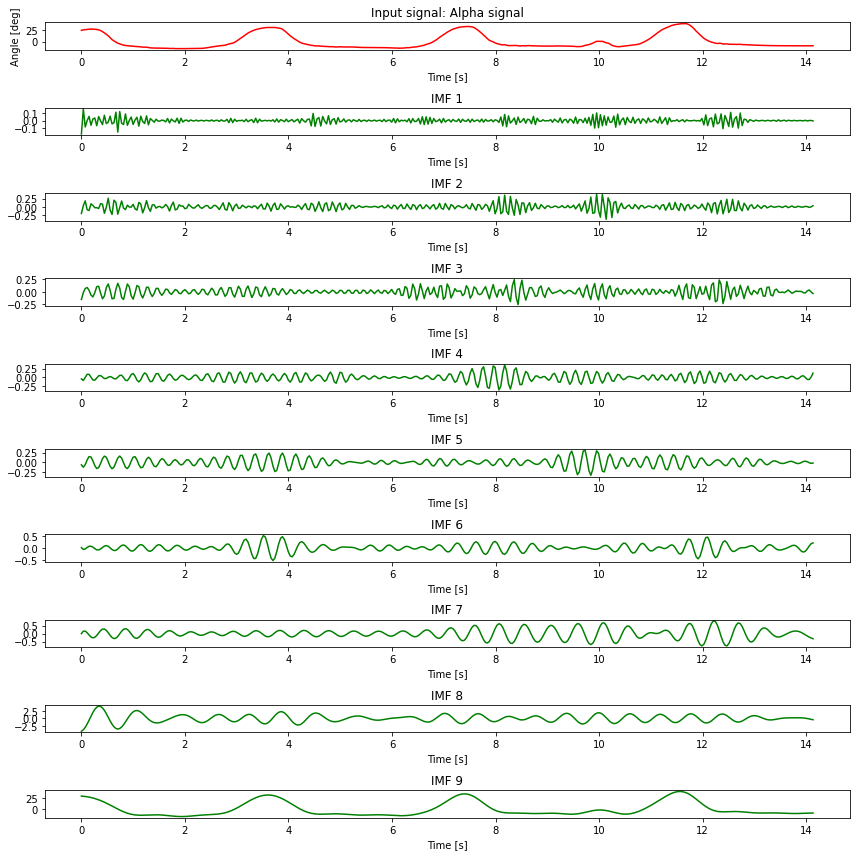

time: 5.32 s (started: 2022-10-07 14:02:34 +00:00)


In [ ]:
imfs = tvfemd(alpha).T

N = imfs.shape[0]+1

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(N,1,1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n, imf in enumerate(imfs):
    plt.subplot(N,1,n+2)
    plt.plot(time, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

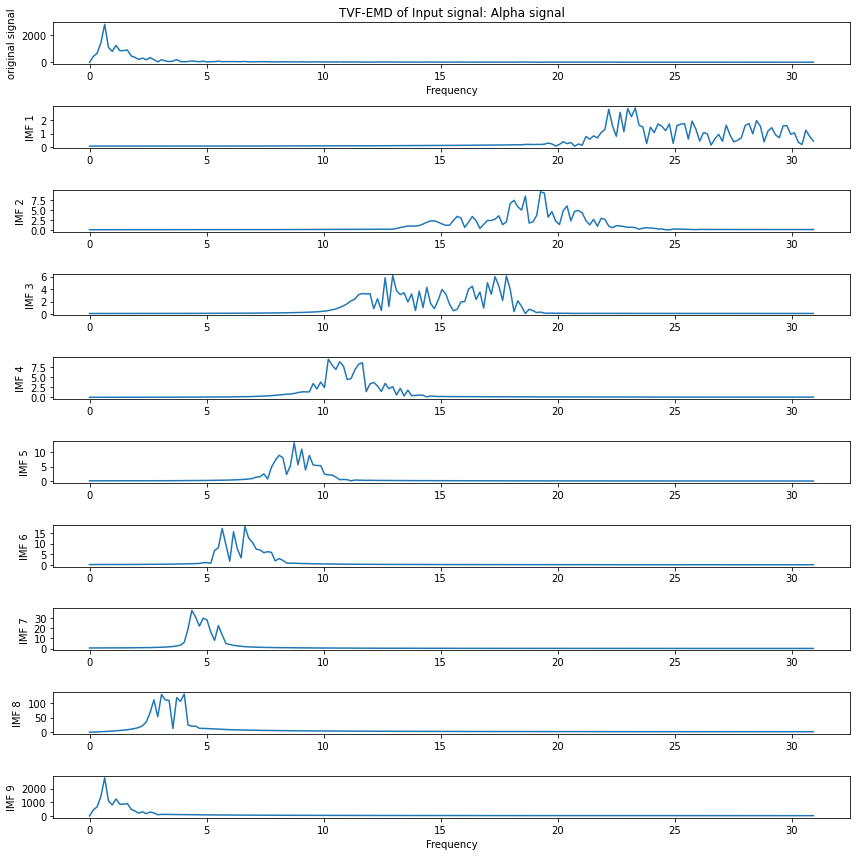

time: 1.16 s (started: 2022-10-07 14:02:39 +00:00)


In [ ]:
# Plot results
nIMFs = imfs.shape[0]
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
# fourier = fft(signal)
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
# freq = fftfreq(n, d=1/SampleRate)
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("TVF-EMD of Input signal: Alpha signal")
plt.xlabel("Frequency")
plt.ylabel("original signal")

for n, imf in enumerate(imfs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imf
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# PD1_REST

In [ ]:
pathL = "https://github.com/JackyL504/FYP/raw/main/PD1_REST/TestDataL.xlsx"
pathP = "https://github.com/JackyL504/FYP/raw/main/PD1_REST/TestDataP.xlsx"
pathU = "https://github.com/JackyL504/FYP/raw/main/PD1_REST/TestDataU.xlsx"
lower_arm = pd.read_excel(pathL,"TestDataL", header=None)
palm = pd.read_excel(pathP, "TestDataP", header=None)
upper_arm = pd.read_excel(pathU, "TestDataU", header=None)
# lower_arm = pd.read_csv(path)

timeRaw = (lower_arm[0]/1000).array
alphaRaw = lower_arm[1].array
betaRaw = lower_arm[2].array
gammaRaw = lower_arm[3].array


time: 4.85 s (started: 2022-10-06 11:55:43 +00:00)


## Data Preprocessing
- Interpolation
- Detrend

In [ ]:
# Interpolation
TimeSample = 0.037
timeRaw = timeRaw - timeRaw[0]
time = np.arange(timeRaw[0], timeRaw[-1], TimeSample)
alpha = scipy.interpolate.pchip_interpolate(timeRaw, alphaRaw, time)
# beta = scipy.interpolate.pchip_interpolate(timeRaw, betaRaw, time)
# gamma = scipy.interpolate.pchip_interpolate(timeRaw, gammaRaw, time)

# Detrend
alpha = scipy.signal.detrend(alpha)
# beta = scipy.signal.detrend(beta)
# gamma = scipy.signal.detrend(gamma)


time: 5.19 ms (started: 2022-10-06 11:55:48 +00:00)


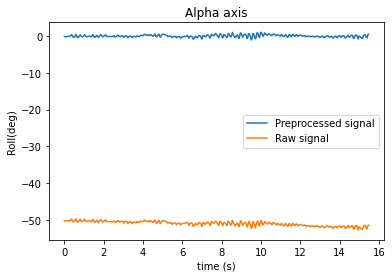

time: 256 ms (started: 2022-10-06 11:55:48 +00:00)


In [ ]:
# Plot 
plt.figure()
plt.plot(time, alpha, label = "Preprocessed signal")
plt.plot(timeRaw, alphaRaw, label = "Raw signal")
plt.xlabel('time (s)')
plt.ylabel('Roll(deg)')
plt.title('Alpha axis')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(time, beta, label = "Preprocessed signal")
# plt.plot(timeRaw, betaRaw, label = "Raw signal")
# plt.xlabel('time (s)')
# plt.ylabel('Pitch(deg)')
# plt.title('Beta axis')
# plt.legend(loc = "upper right")
# plt.show()

# plt.figure()
# plt.plot(time, gamma, label = "Preprocessed signal")
# plt.plot(timeRaw, gammaRaw, label = "Raw signal")
# plt.xlabel('time (s)')
# plt.ylabel('Yaw(deg)')
# plt.title('Gamma axis')
# plt.legend()
# plt.show()

## Signal Decomposition
### EMD

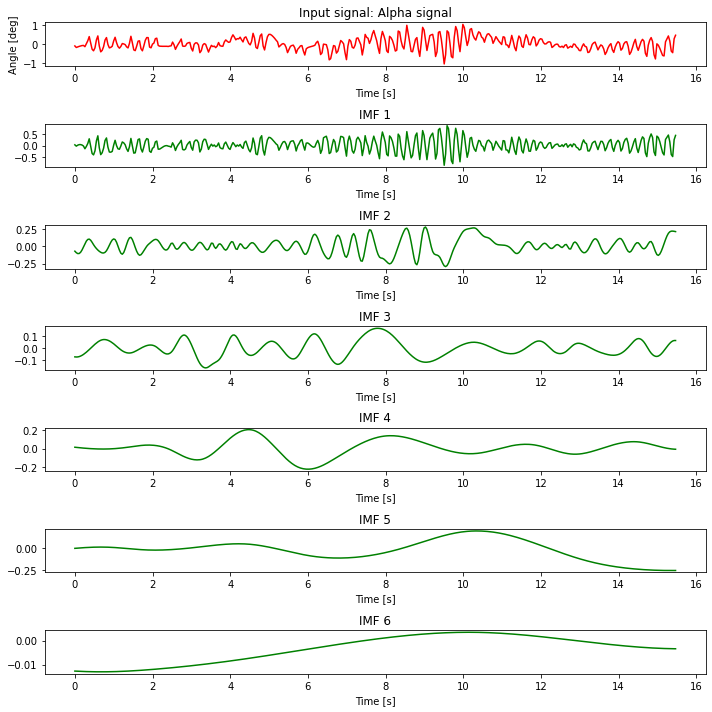

time: 1.27 s (started: 2022-10-06 11:55:48 +00:00)


In [ ]:
IMFs = EMD().emd(alpha,time)
N = IMFs.shape[0]+1

# Plot results
plt.figure(figsize=(10, 10))
plt.subplot(N,1,1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n, imf in enumerate(IMFs):
    plt.subplot(N,1,n+2)
    plt.plot(time, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

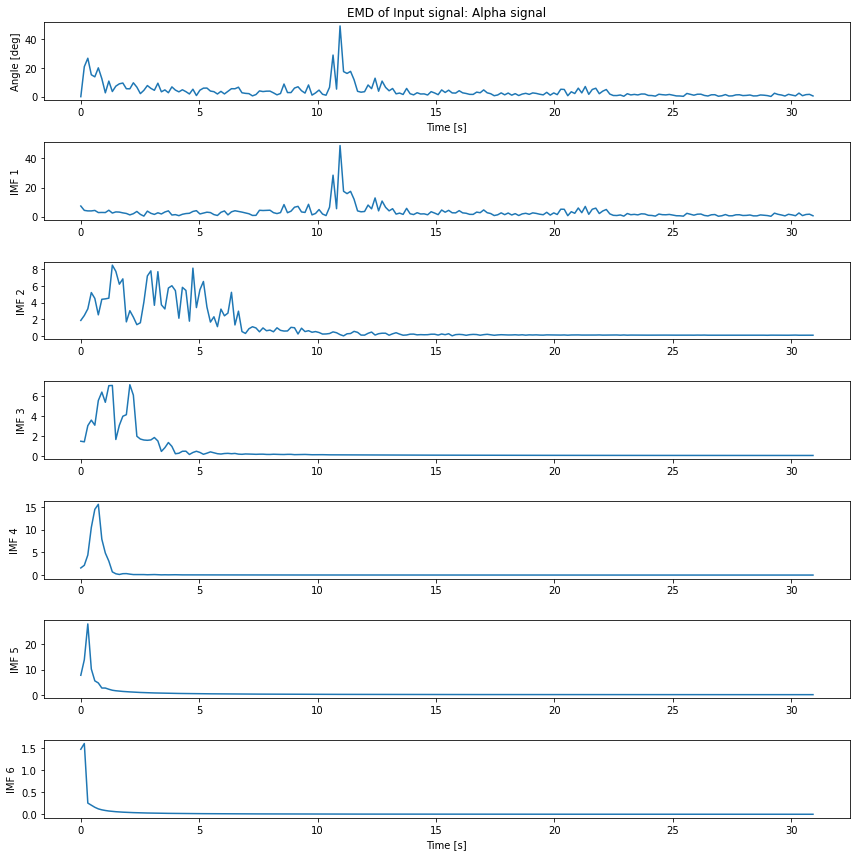

time: 1.2 s (started: 2022-10-06 11:55:50 +00:00)


In [ ]:
# Plot results
nIMFs = IMFs.shape[0]
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EMD of Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n, imf in enumerate(IMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imf
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

### EEMD

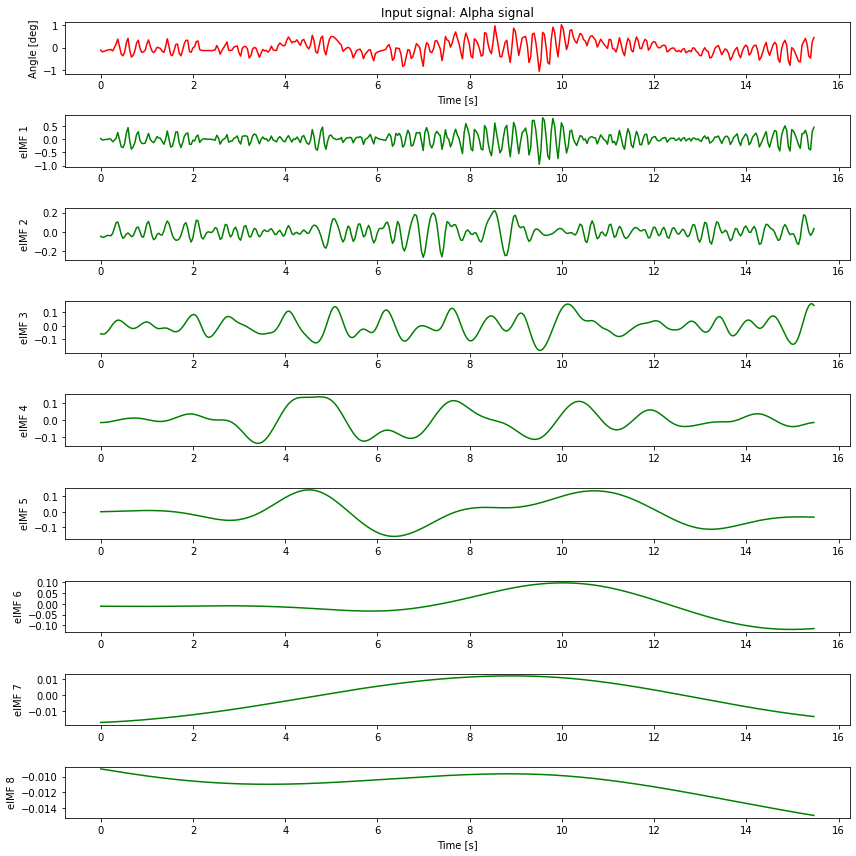

time: 5.94 s (started: 2022-10-06 11:55:51 +00:00)


In [ ]:
# Assign EEMD to `eemd` variable
eemd = EEMD()

# Say we want detect extrema using parabolic method
eemd.EMD.extrema_detection="parabol"

# Execute EEMD on S
eIMFs = eemd.eemd(alpha, time)
nIMFs = eIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(time, eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

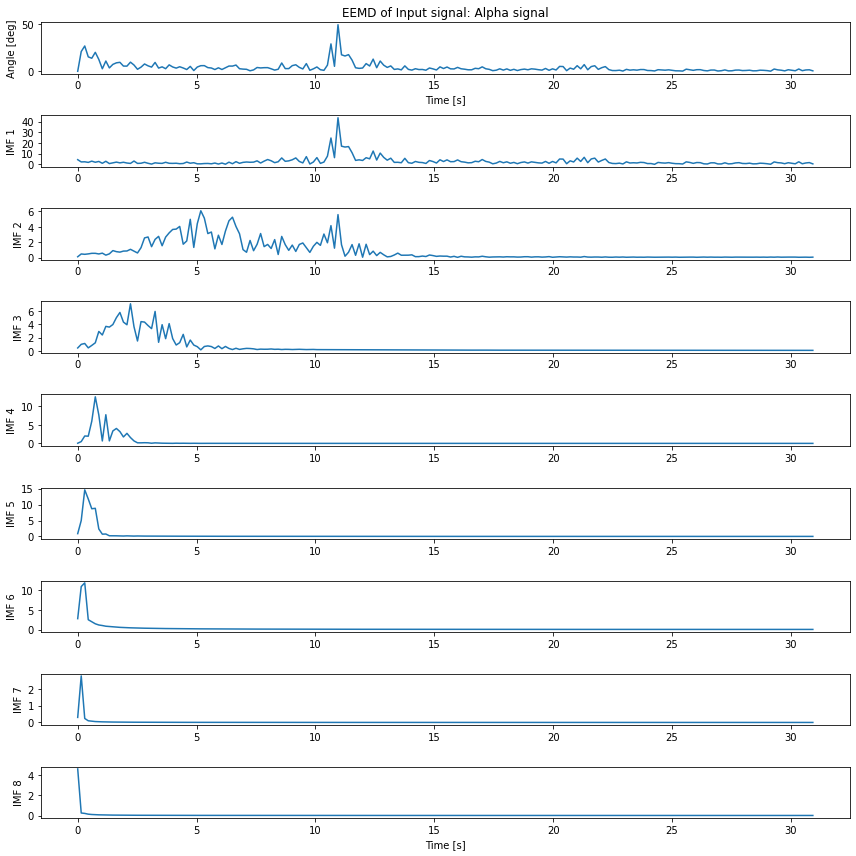

time: 1.27 s (started: 2022-10-06 11:55:57 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EEMD of Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = eIMFs[n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

### CEEMDAN

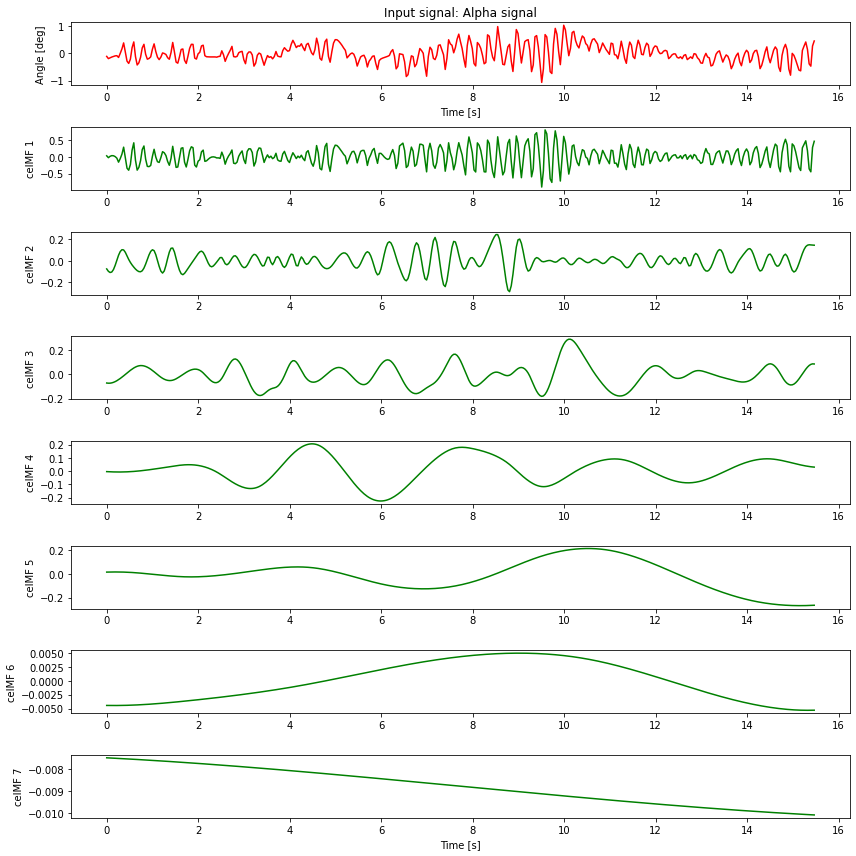

time: 9.5 s (started: 2022-10-06 11:55:58 +00:00)


In [ ]:
ceemdan = CEEMDAN()

# Say we want detect extrema using parabolic method
ceemdan.EMD.extrema_detection="parabol"

# Execute CEEMDAN on S
ceIMFs = ceemdan.ceemdan(alpha, time)
cnIMFs = ceIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(cnIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(cnIMFs):
    plt.subplot(cnIMFs+1, 1, n+2)
    plt.plot(time, ceIMFs[n], 'g')
    plt.ylabel("ceIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

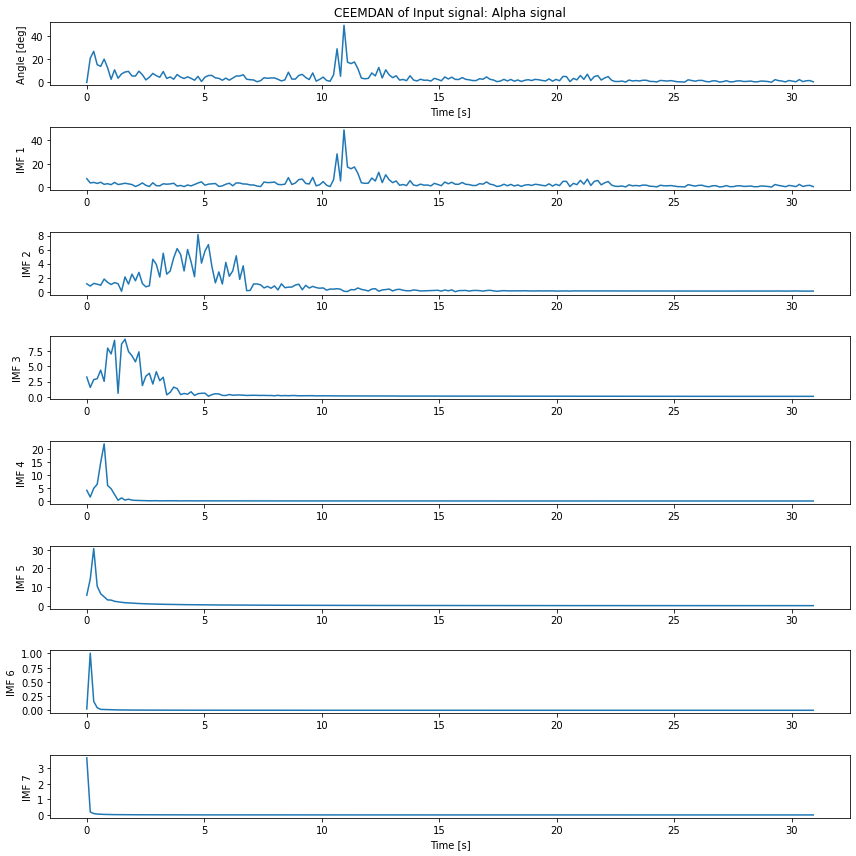

time: 1.22 s (started: 2022-10-06 11:56:08 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(cnIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("CEEMDAN of Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(cnIMFs):
    plt.subplot(cnIMFs+1, 1, n+2)
    signal = ceIMFs[n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

### TVF-EMD

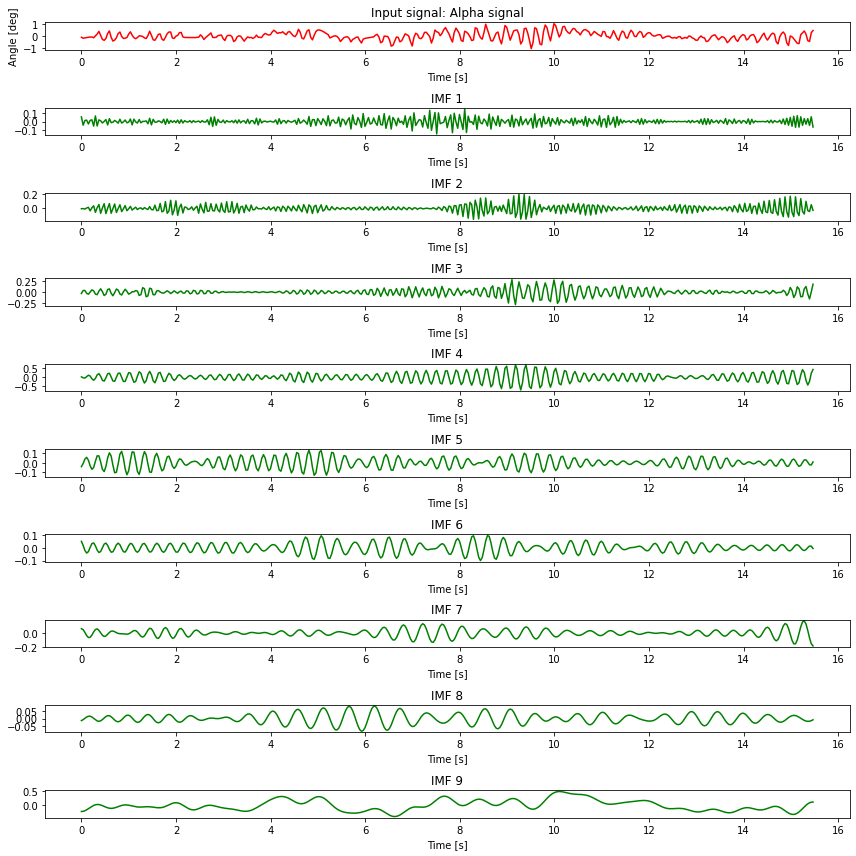

time: 5.8 s (started: 2022-10-06 11:56:09 +00:00)


In [ ]:
imfs = tvfemd(alpha).T

N = imfs.shape[0]+1

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(N,1,1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n, imf in enumerate(imfs):
    plt.subplot(N,1,n+2)
    plt.plot(time, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

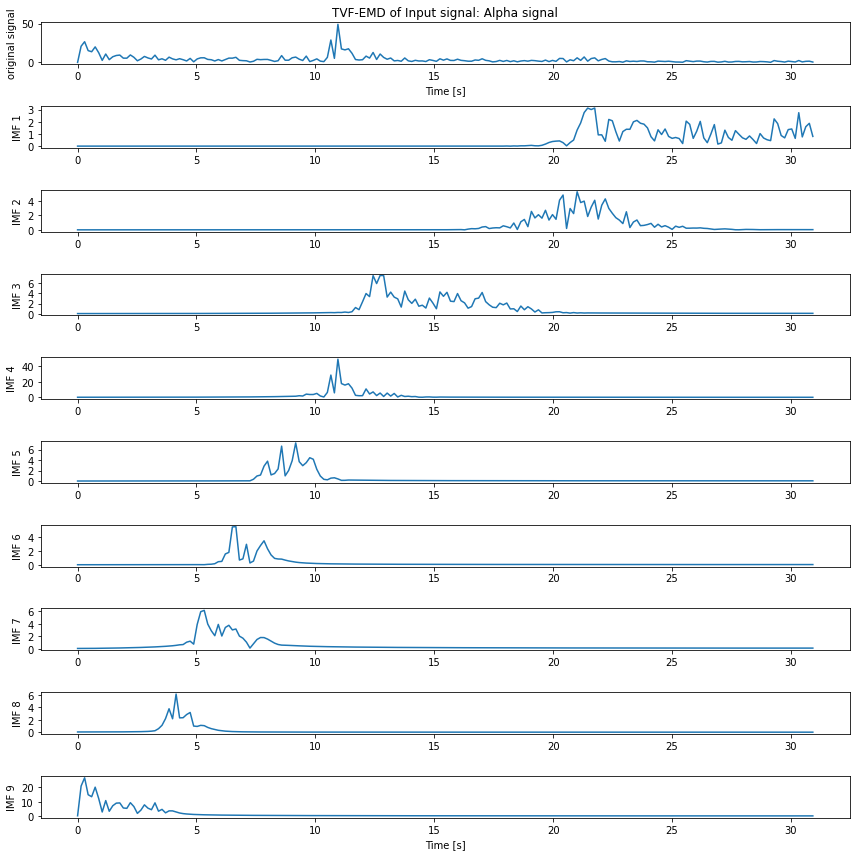

time: 1.62 s (started: 2022-10-06 11:56:15 +00:00)


In [ ]:
# Plot results
nIMFs = imfs.shape[0]
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("TVF-EMD of Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("original signal")

for n, imf in enumerate(imfs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imf
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

### Masked EMD


In [ ]:
# imf = emd.sift.mask_sift(alpha, mask_amp = 0.4, mask_freqs=10*TimeSample, mask_step_factor = 2, max_imfs=20)
# imf = emd.sift.iterated_mask_sift(alpha, mask_amp = 1, sample_rate=(1/TimeSample), max_imfs=5, mask_0='zc')
imf = emd.sift.iterated_mask_sift(alpha, mask_amp = 1, sample_rate=62, max_imfs=5, mask_0='zc')

# emd.plotting.plot_imfs(imf)

time: 556 ms (started: 2022-10-06 11:56:16 +00:00)


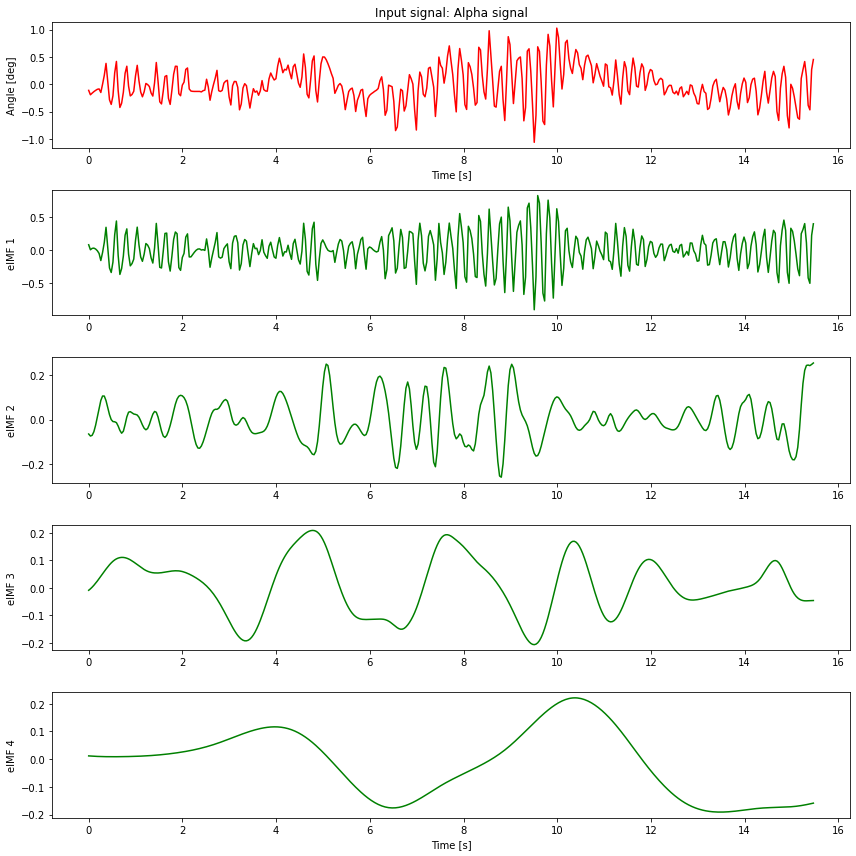

time: 892 ms (started: 2022-10-06 11:56:17 +00:00)


In [ ]:
nIMFs = imf.shape[1]

# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(time, alpha, 'r')
plt.title("Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(time, imf[:,n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

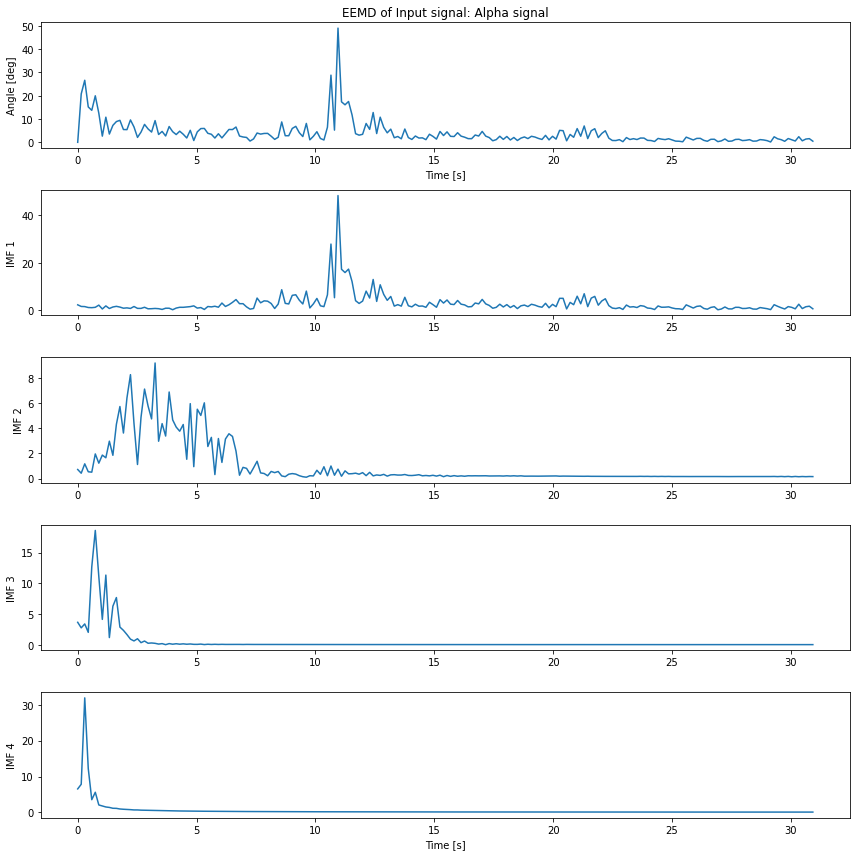

time: 803 ms (started: 2022-10-06 11:56:18 +00:00)


In [ ]:
# Plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMFs+1, 1, 1)
signal = alpha
fourier = rfft(signal)
n = signal.size
timestep = TimeSample
freq = rfftfreq(n, d=1/SampleRate)
plt.plot(freq, np.abs(fourier))
plt.title("EEMD of Input signal: Alpha signal")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    signal = imf[:,n]
    fourier = rfft(signal)
    N = signal.size
    timestep = TimeSample
    freq = rfftfreq(N, d=1/SampleRate)
    plt.plot(freq, np.abs(fourier))
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

# PD1_DRINK2


In [ ]:
pathL = "https://github.com/JackyL504/FYP/raw/main/PD1-DRINK2/TestDataL.xlsx"
pathP = "https://github.com/JackyL504/FYP/raw/main/PD1-DRINK2/TestDataP.xlsx"
pathU = "https://github.com/JackyL504/FYP/raw/main/PD1-DRINK2/TestDataU.xlsx"
lower_arm = pd.read_excel(pathL,"TestDataL", header=None)
palm = pd.read_excel(pathP, "TestDataP", header=None)
upper_arm = pd.read_excel(pathU, "TestDataU", header=None)
# lower_arm = pd.read_csv(path)

timeRaw = (lower_arm[0]/1000).array
alphaRaw = lower_arm[1].array
betaRaw = lower_arm[2].array
gammaRaw = lower_arm[3].array


time: 4.02 s (started: 2022-10-06 11:56:19 +00:00)


## Data Preprocessing
- Interpolation
- Detrend

In [ ]:
# Interpolation
TimeSample = 0.037
timeRaw = timeRaw - timeRaw[0]
time = np.arange(timeRaw[0], timeRaw[-1], TimeSample)
alpha = scipy.interpolate.pchip_interpolate(timeRaw, alphaRaw, time)
# beta = scipy.interpolate.pchip_interpolate(timeRaw, betaRaw, time)
# gamma = scipy.interpolate.pchip_interpolate(timeRaw, gammaRaw, time)

# Detrend
alpha = scipy.signal.detrend(alpha)
# beta = scipy.signal.detrend(beta)
# gamma = scipy.signal.detrend(gamma)


time: 4.29 ms (started: 2022-10-06 11:56:23 +00:00)


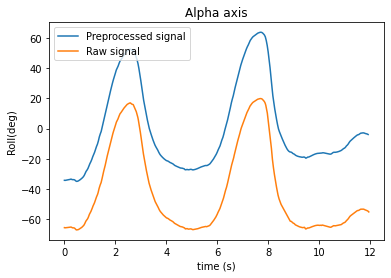

time: 200 ms (started: 2022-10-06 11:56:23 +00:00)


In [ ]:
# Plot 
plt.figure()
plt.plot(time, alpha, label = "Preprocessed signal")
plt.plot(timeRaw, alphaRaw, label = "Raw signal")
plt.xlabel('time (s)')
plt.ylabel('Roll(deg)')
plt.title('Alpha axis')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(time, beta, label = "Preprocessed signal")
# plt.plot(timeRaw, betaRaw, label = "Raw signal")
# plt.xlabel('time (s)')
# plt.ylabel('Pitch(deg)')
# plt.title('Beta axis')
# plt.legend(loc = "upper right")
# plt.show()

# plt.figure()
# plt.plot(time, gamma, label = "Preprocessed signal")
# plt.plot(timeRaw, gammaRaw, label = "Raw signal")
# plt.xlabel('time (s)')
# plt.ylabel('Yaw(deg)')
# plt.title('Gamma axis')
# plt.legend()
# plt.show()

## Signal Decomposition



